In [ ]:
# Data Set Creation
import os

import cv2


DATA_DIR = './datanew_words'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

number_of_classes = #hu many data cls do u wnt?
dataset_size = 500

cap = cv2.VideoCapture(0)
for j in range(number_of_classes):
    if not os.path.exists(os.path.join(DATA_DIR, str(j))):
        os.makedirs(os.path.join(DATA_DIR, str(j)))

    print('Collecting data for class {}'.format(j))

    done = False
    while True:
        ret, frame = cap.read()
        cv2.putText(frame, 'Ready? Press "Q" ! :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = 0
    while counter < dataset_size:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        cv2.imwrite(os.path.join(DATA_DIR, str(j), '{}.jpg'.format(counter)), frame)

        counter += 1

cap.release()
cv2.destroyAllWindows()


In [2]:
#creating pikle
import os
import pickle
import mediapipe as mp
import cv2

def process_dataset(data_dir, output_file):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

    data = []
    labels = []

    for dir_ in os.listdir(data_dir):
        for img_path in os.listdir(os.path.join(data_dir, dir_)):
            data_aux = []

            img = cv2.imread(os.path.join(data_dir, dir_, img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                landmarks = results.multi_hand_landmarks[0].landmark
                min_x = min(landmark.x for landmark in landmarks)
                min_y = min(landmark.y for landmark in landmarks)

                for landmark in landmarks:
                    data_aux.extend([landmark.x - min_x, landmark.y - min_y])

                data.append(data_aux)
                labels.append(dir_)

    with open(output_file, 'wb') as f:
        pickle.dump({'data': data, 'labels': labels}, f)


# Process isl dataset
process_dataset('C:\\Users\\Admin\\handsigndetection\\isl', 'isl.pickle')




Accuracy: 1.0
Confusion Matrix:
 [[ 40   0   0   0   0   0]
 [  0  96   0   0   0   0]
 [  0   0 100   0   0   0]
 [  0   0   0 100   0   0]
 [  0   0   0   0 100   0]
 [  0   0   0   0   0 100]]


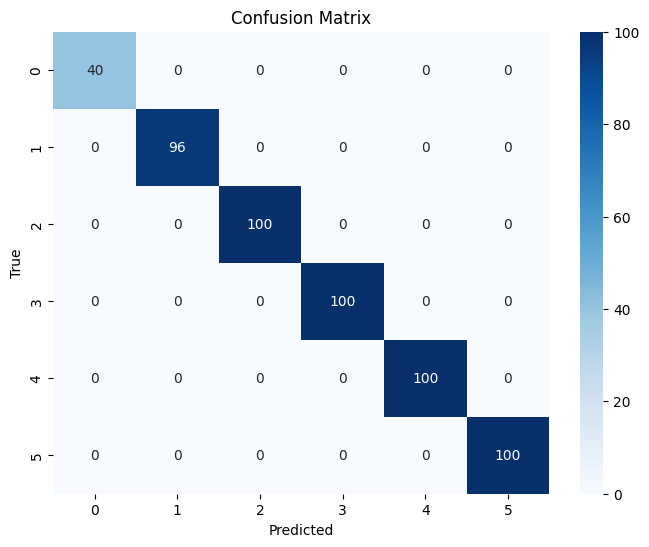

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        96
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100

    accuracy                           1.00       536
   macro avg       1.00      1.00      1.00       536
weighted avg       1.00      1.00      1.00       536



In [5]:
#training the model
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def load_data_and_preprocess(file_path):
    data_dict = pickle.load(open(file_path, 'rb'))
    data = np.asarray(data_dict['data'])
    labels = np.asarray(data_dict['labels'])
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    return data, labels, label_encoder

def train_and_evaluate_model(data, labels, label_encoder, model_save_path):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)
    
    model = RandomForestClassifier()
    model.fit(x_train, y_train)

    y_predict = model.predict(x_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_predict)
    print('Accuracy:', accuracy)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_predict)
    print('Confusion Matrix:\n', conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    class_report = classification_report(y_test, y_predict, target_names=label_encoder.classes_)
    print('Classification Report:\n', class_report)

    # Save the trained model
    with open(model_save_path, 'wb') as f:
        pickle.dump({'model': model, 'label_encoder': label_encoder}, f)

# Process isl dataset
data_isl, labels_isl, label_encoder_isl = load_data_and_preprocess('C:\\Users\\Admin\\handsigndetection\\isl.pickle')
train_and_evaluate_model(data_isl, labels_isl, label_encoder_isl, 'isl.p')



In [6]:
#-Q-stop
#-n-new classification model

In [7]:
#Detection with hand not detected
import pickle
import cv2
import mediapipe as mp
import numpy as np

def process_hand_landmarks(hand_landmarks, W, H):
    data_aux = []
    x_ = []
    y_ = []

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y

        x_.append(x)
        y_.append(y)

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y
        data_aux.append(x - min(x_))
        data_aux.append(y - min(y_))

    x1 = int(min(x_) * W) - 10
    y1 = int(min(y_) * H) - 10

    x2 = int(max(x_) * W) - 10
    y2 = int(max(y_) * H) - 10

    return data_aux, x1, y1, x2, y2

def main(model_paths, labels_dicts):
    active_model_index = 0
    models = [pickle.load(open(model_path, 'rb'))['model'] for model_path in model_paths]

    cap = cv2.VideoCapture(0)

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

    while True:
        ret, frame = cap.read()
        H, W, _ = frame.shape

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            for hand_landmarks in results.multi_hand_landmarks:
                data_aux, x1, y1, x2, y2 = process_hand_landmarks(hand_landmarks, W, H)

                prediction = models[active_model_index].predict([np.asarray(data_aux)])
                predicted_character = labels_dicts[active_model_index][int(prediction[0])]

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
                cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3,
                            cv2.LINE_AA)
        else:
            cv2.putText(frame, "Hand not detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        cv2.imshow('frame', frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        elif key == ord('n'):
            active_model_index = (active_model_index + 1) % len(models)

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    model_paths = ['./isl.p']

    labels_dicts = [  
         {0: 'Hi', 1: 'Thank you', 2: 'Lift', 3: 'No', 4: 'call', 5: 'Good Luck',}
    ]

    main(model_paths, labels_dicts)
#6:'smile',7:'punch',8:'nice',9:'strong',10:'little'

In [8]:
#############practise works

In [9]:
import pickle
import cv2
import mediapipe as mp
import numpy as np

def process_hand_landmarks(hand_landmarks, W, H):
    data_aux = []
    x_ = []
    y_ = []

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y

        x_.append(x)
        y_.append(y)

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y
        data_aux.append(x - min(x_))
        data_aux.append(y - min(y_))

    x1 = int(min(x_) * W) - 10
    y1 = int(min(y_) * H) - 10

    x2 = int(max(x_) * W) - 10
    y2 = int(max(y_) * H) - 10

    return data_aux, x1, y1, x2, y2

def main(model_paths, labels_dicts):
    active_model_index = 0
    models = [pickle.load(open(model_path, 'rb'))['model'] for model_path in model_paths]

    cap = cv2.VideoCapture(0)

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

    recognized_words = []  # New array to store recognized words

    while True:
        ret, frame = cap.read()
        H, W, _ = frame.shape

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            for hand_landmarks in results.multi_hand_landmarks:
                data_aux, x1, y1, x2, y2 = process_hand_landmarks(hand_landmarks, W, H)

                prediction = models[active_model_index].predict([np.asarray(data_aux)])
                predicted_character = labels_dicts[active_model_index][int(prediction[0])]

                recognized_words.append(predicted_character)  # Append recognized word to the array

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
                cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3,
                            cv2.LINE_AA)
        else:
            cv2.putText(frame, "Hand not detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        cv2.imshow('frame', frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
        elif key == ord('n'):
            active_model_index = (active_model_index + 1) % len(models)

    cap.release()
    cv2.destroyAllWindows()

    print("Recognized Words:", recognized_words)  # Print the recognized words array

if __name__ == "__main__":
    model_paths = ['./isl.p']

    labels_dicts = [  
         {0: 'Hi', 1: 'Thank you', 2: 'Lift', 3: 'No', 4: 'call', 5: 'Good Luck'}
    ]

    main(model_paths, labels_dicts)


Recognized Words: ['No']


In [10]:

import pickle
import cv2
import mediapipe as mp
import numpy as np
import time
import nltk
from nltk import sent_tokenize, word_tokenize

# Download the 'punkt' resource if not already downloaded
nltk.download('punkt', quiet=True)

def process_hand_landmarks(hand_landmarks, W, H):
    data_aux = []
    x_ = []
    y_ = []

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y

        x_.append(x)
        y_.append(y)

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y
        data_aux.append(x - min(x_))
        data_aux.append(y - min(y_))

    x1 = int(min(x_) * W) - 10
    y1 = int(min(y_) * H) - 10

    x2 = int(max(x_) * W) - 10
    y2 = int(max(y_) * H) - 10

    return data_aux, x1, y1, x2, y2

def check_consistency(buffer, target_word, consistency_duration=3):
    current_time = time.time()

    if len(buffer) == 0 or buffer[-1][0] != target_word:
        buffer.append((target_word, current_time))
        return False

    if current_time - buffer[-1][1] >= consistency_duration:
        return True

    return False

def construct_sentence(words):
    sentence = ' '.join(words)
    sentences = sent_tokenize(sentence)
    if sentences:
        return sentences[0]  # Take the first sentence
    return ""

def main(model_paths, labels_dicts):
    active_model_index = 0
    models = [pickle.load(open(model_path, 'rb'))['model'] for model_path in model_paths]

    cap = cv2.VideoCapture(0)

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

    recognized_words_buffer = []  # Buffer to store recognized words and timestamps
    current_sentence = []  # List to store words forming the current sentence

    while True:
        ret, frame = cap.read()
        H, W, _ = frame.shape

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            for hand_landmarks in results.multi_hand_landmarks:
                data_aux, x1, y1, x2, y2 = process_hand_landmarks(hand_landmarks, W, H)

                prediction = models[active_model_index].predict([np.asarray(data_aux)])
                predicted_character = labels_dicts[active_model_index][int(prediction[0])]

                if check_consistency(recognized_words_buffer, predicted_character):
                    recognized_words_buffer = []  # Reset the buffer after processing
                    current_sentence.append(predicted_character)

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
                cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3,
                            cv2.LINE_AA)

            # Display the forming sentence on the frame
            sentence_display = construct_sentence(current_sentence)
            cv2.putText(frame, f"Sentence: {sentence_display}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2,
                        cv2.LINE_AA)

        else:
            cv2.putText(frame, "Hand not detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        cv2.imshow('frame', frame)
        key = cv2.waitKey(1)

        if key == ord('q'):
            break
        elif key == ord('n'):
            active_model_index = (active_model_index + 1) % len(models)

    cap.release()
    cv2.destroyAllWindows()

    final_sentence = construct_sentence(current_sentence)
    if final_sentence:
        print("Final Sentence:", final_sentence)
    else:
        print("No sentence formed.")

if __name__ == "__main__":
    model_paths = ['./isl.p']

    labels_dicts = [
        {0: 'Hi', 1: 'Thank you', 2: 'Lift', 3: 'No', 4: 'call', 5: 'Good Luck'}
    ]

    main(model_paths, labels_dicts)


No sentence formed.


In [11]:
import pickle
import cv2
import mediapipe as mp
import numpy as np
import time
import nltk
from nltk import sent_tokenize, word_tokenize

# Download the 'punkt' resource if not already downloaded
nltk.download('punkt', quiet=True)

def process_hand_landmarks(hand_landmarks, W, H):
    data_aux = []
    x_ = []
    y_ = []

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y

        x_.append(x)
        y_.append(y)

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y
        data_aux.append(x - min(x_))
        data_aux.append(y - min(y_))

    x1 = int(min(x_) * W) - 10
    y1 = int(min(y_) * H) - 10

    x2 = int(max(x_) * W) - 10
    y2 = int(max(y_) * H) - 10

    return data_aux, x1, y1, x2, y2

def check_consistency(buffer, target_word, consistency_duration=3):
    current_time = time.time()

    if len(buffer) == 0 or buffer[-1][0] != target_word:
        buffer.append((target_word, current_time))
        return False

    if current_time - buffer[-1][1] >= consistency_duration:
        return True

    return False

def construct_sentence(words):
    sentence = ' '.join(words)
    sentences = sent_tokenize(sentence)
    if sentences:
        return sentences[0]  # Take the first sentence
    return ""

def generate_output(predicted_words):
    # Simple rule-based output generation
    if 'Hi' in predicted_words and 'call' in predicted_words:
        return "Hi call me"
    elif 'Thank you' in predicted_words and 'Lift' in predicted_words:
        return "Thank you for the lift"
    # Add more rules based on your use case

    return construct_sentence(predicted_words)

def main(model_paths, labels_dicts):
    active_model_index = 0
    models = [pickle.load(open(model_path, 'rb'))['model'] for model_path in model_paths]

    cap = cv2.VideoCapture(0)

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

    recognized_words_buffer = []  # Buffer to store recognized words and timestamps
    current_sentence = []  # List to store words forming the current sentence

    while True:
        ret, frame = cap.read()
        H, W, _ = frame.shape

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            for hand_landmarks in results.multi_hand_landmarks:
                data_aux, x1, y1, x2, y2 = process_hand_landmarks(hand_landmarks, W, H)

                prediction = models[active_model_index].predict([np.asarray(data_aux)])
                predicted_character = labels_dicts[active_model_index][int(prediction[0])]

                if check_consistency(recognized_words_buffer, predicted_character):
                    recognized_words_buffer = []  # Reset the buffer after processing
                    current_sentence.append(predicted_character)

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
                cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3,
                            cv2.LINE_AA)

            # Display the forming sentence on the frame
            sentence_display = construct_sentence(current_sentence)
            cv2.putText(frame, f"Sentence: {sentence_display}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2,
                        cv2.LINE_AA)

        else:
            cv2.putText(frame, "Hand not detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        cv2.imshow('frame', frame)
        key = cv2.waitKey(1)

        if key == ord('q'):
            break
        elif key == ord('n'):
            active_model_index = (active_model_index + 1) % len(models)

    cap.release()
    cv2.destroyAllWindows()

    predicted_sentence = generate_output(current_sentence)
    print("Predicted Output:", predicted_sentence)

if __name__ == "__main__":
    model_paths = ['./isl.p']

    labels_dicts = [
        {0: 'Hi', 1: 'Thank you', 2: 'Lift', 3: 'No', 4: 'call', 5: 'Good Luck'}
    ]

    main(model_paths, labels_dicts)


Predicted Output: 


In [15]:
import pickle
import cv2
import mediapipe as mp
import numpy as np
import time
import nltk
from nltk import sent_tokenize, word_tokenize

# Download the 'punkt' resource if not already downloaded
nltk.download('punkt', quiet=True)

def process_hand_landmarks(hand_landmarks, W, H):
    data_aux = []
    x_ = []
    y_ = []

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y

        x_.append(x)
        y_.append(y)

    for i in range(len(hand_landmarks.landmark)):
        x = hand_landmarks.landmark[i].x
        y = hand_landmarks.landmark[i].y
        data_aux.append(x - min(x_))
        data_aux.append(y - min(y_))

    x1 = int(min(x_) * W) - 10
    y1 = int(min(y_) * H) - 10

    x2 = int(max(x_) * W) - 10
    y2 = int(max(y_) * H) - 10

    return data_aux, x1, y1, x2, y2

def check_consistency(buffer, target_word, consistency_duration=3):
    current_time = time.time()

    if len(buffer) == 0 or buffer[-1][0] != target_word:
        buffer.append((target_word, current_time))
        return False

    if current_time - buffer[-1][1] >= consistency_duration:
        return True

    return False

def construct_sentence(words, word_meanings):
    sentence = ' '.join(words)
    sentences = sent_tokenize(sentence)
    if sentences:
        return sentences[0]  # Take the first sentence
    return ""

def generate_output(predicted_words, word_meanings):
    meanings = [word_meanings[word] for word in predicted_words if word in word_meanings]
    return ' '.join(meanings)

def main(model_paths, labels_dict, word_meanings):
    active_model_index = 0
    models = [pickle.load(open(model_path, 'rb'))['model'] for model_path in model_paths]

    cap = cv2.VideoCapture(0)

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

    recognized_words_buffer = []  # Buffer to store recognized words and timestamps
    current_sentence = []  # List to store words forming the current sentence

    while True:
        ret, frame = cap.read()
        H, W, _ = frame.shape

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            for hand_landmarks in results.multi_hand_landmarks:
                data_aux, x1, y1, x2, y2 = process_hand_landmarks(hand_landmarks, W, H)

                prediction = models[active_model_index].predict([np.asarray(data_aux)])
                predicted_character = labels_dict[active_model_index][int(prediction[0])]

                if check_consistency(recognized_words_buffer, predicted_character):
                    recognized_words_buffer = []  # Reset the buffer after processing
                    current_sentence.append(predicted_character)

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
                cv2.putText(frame, str(predicted_character), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3,
                            cv2.LINE_AA)

            # Display the forming sentence on the frame
            sentence_display = construct_sentence(current_sentence, word_meanings)
            cv2.putText(frame, f"Sentence: {sentence_display}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2,
                        cv2.LINE_AA)

        else:
            cv2.putText(frame, "Hand not detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        cv2.imshow('frame', frame)
        key = cv2.waitKey(1)

        if key == ord('q'):
            break
        elif key == ord('n'):
            active_model_index = (active_model_index + 1) % len(models)

    cap.release()
    cv2.destroyAllWindows()

    predicted_sentence = generate_output(current_sentence, word_meanings)
    print("Predicted Output:", predicted_sentence)

if __name__ == "__main__":
    model_paths = ['./isl.p']

    labels_dicts = [
        {0: 'Hi', 1: 'Thank you', 2: 'Lift', 3: 'No', 4: 'call', 5: 'Good Luck'}
    ]

    word_meanings = {
        'Hi': 'Hey hi',
        'Thank you': 'Thank you for support',
        'Lift': 'give me a lift',
        'No': ' No,it\'s ok',
        'call': ' call me',
        'Good Luck': ' good luck for your work'
    }

    main(model_paths, labels_dicts, word_meanings)


Predicted Output:  call me  call me  call me  call me  call me  call me
